In [1]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV3Small, MobileNetV3Large
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

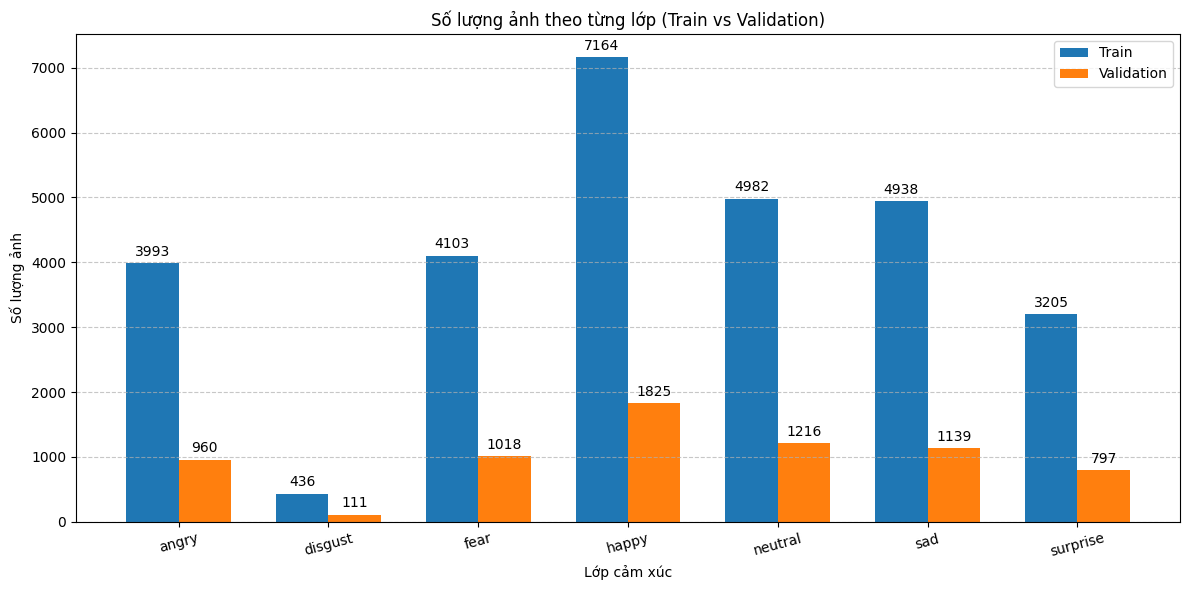

In [2]:
import os
import matplotlib.pyplot as plt
import numpy as np

# Đường dẫn
train_dir = 'D:/DatasetDoAnCoSO/dataset_emotion/images/train'
val_dir = 'D:/DatasetDoAnCoSO/dataset_emotion/images/validation'

# Lấy danh sách lớp
classes = os.listdir(train_dir)
train_counts = []
val_counts = []

# Đếm ảnh
for cls in classes:
    train_path = os.path.join(train_dir, cls)
    val_path = os.path.join(val_dir, cls)

    train_count = len(os.listdir(train_path)) if os.path.exists(train_path) else 0
    val_count = len(os.listdir(val_path)) if os.path.exists(val_path) else 0

    train_counts.append(train_count)
    val_counts.append(val_count)

# Vẽ biểu đồ
x = np.arange(len(classes))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 6))
rects1 = ax.bar(x - width/2, train_counts, width, label='Train')
rects2 = ax.bar(x + width/2, val_counts, width, label='Validation')

ax.set_ylabel('Số lượng ảnh')
ax.set_xlabel('Lớp cảm xúc')
ax.set_title('Số lượng ảnh theo từng lớp (Train vs Validation)')
ax.set_xticks(x)
ax.set_xticklabels(classes, rotation=15)
ax.legend()
ax.grid(axis='y', linestyle='--', alpha=0.7)

# Hiển thị số lượng trên đầu mỗi cột
for rects in [rects1, rects2]:
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 điểm pixel lên trên
                    textcoords="offset points",
                    ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [3]:
emotion_labels = sorted(os.listdir(train_dir))
print("Các thư mục nhãn có trong train_dir:")
print(emotion_labels)

for label in emotion_labels:
    label_path = os.path.join(train_dir, label)
    print(f"{label}: {len(os.listdir(label_path))} ảnh")

Các thư mục nhãn có trong train_dir:
['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
angry: 3993 ảnh
disgust: 436 ảnh
fear: 4103 ảnh
happy: 7164 ảnh
neutral: 4982 ảnh
sad: 4938 ảnh
surprise: 3205 ảnh


In [4]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Cấu hình chung
IMG_SIZE = (56, 56)
BATCH_SIZE = 16
COLOR_MODE = "grayscale"

# Augmentation giống CNN
train_datagen = ImageDataGenerator(
    rescale=1./255.0,
    width_shift_range=0.1,
    height_shift_range=0.1,
    rotation_range=20,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)

# Load dữ liệu từ thư mục
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    color_mode=COLOR_MODE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=IMG_SIZE,
    color_mode=COLOR_MODE,
    batch_size=64,
    class_mode='categorical',
    shuffle=False
)

NUM_CLASSES = train_generator.num_classes

Found 28821 images belonging to 7 classes.
Found 7066 images belonging to 7 classes.


In [7]:
from tensorflow.keras.layers import Input, Concatenate, GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.applications import MobileNetV3Small
from tensorflow.keras.optimizers import Adam


# Tạo input đầu vào (grayscale -> RGB bằng cách lặp lại 3 lần)
input_layer = Input(shape=(56, 56, 1))
x = Concatenate()([input_layer, input_layer, input_layer])  # shape thành (56, 56, 3)

# Load MobileNetV3Small
base_model = MobileNetV3Small(
    input_shape=(56, 56, 3),
    include_top=False,
    weights='imagenet',
    input_tensor=x
)
base_model.trainable = False  # Freeze base model

# Thêm các lớp Fully Connected giống CNN
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
output_layer = Dense(NUM_CLASSES, activation='softmax')(x)

# Xây dựng mô hình
model = Model(inputs=input_layer, outputs=output_layer)

# Compile
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

4334752/4334752 [==============================] - 1s 0us/step
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 56, 56, 1)]          0         []                            
                                                                                                  
 concatenate (Concatenate)   (None, 56, 56, 3)            0         ['input_2[0][0]',             
                                                                     'input_2[0][0]',             
                                                                     'input_2[0][0]']             
                                                                                                  
 rescaling_1 (Rescaling)     (None, 56, 56, 3)            0         ['concatenate[0][0]']         
                             

In [8]:
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
# Callback giúp early stop và giảm learning rate
callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ReduceLROnPlateau(patience=3)
]

# Huấn luyện phase 1
history = model.fit(
    train_generator,
    epochs=30,
    validation_data=val_generator,
    callbacks=callbacks
)

# Fine-tune phase 2 – chỉ unfreeze 20 layer cuối
base_model.trainable = True
for layer in base_model.layers[:-20]:
    layer.trainable = False

# Compile lại
model.compile(optimizer=Adam(1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

# Huấn luyện tiếp phase 2
history_finetune = model.fit(
    train_generator,
    epochs=30,
    validation_data=val_generator,
    callbacks=callbacks
)
model.save('emotion_model,keras')
# Vẽ biểu đồ loss và accuracy
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label="Train Accuracy")
plt.plot(history.history['val_accuracy'], label="Val Accuracy")
plt.legend()
plt.title("Accuracy")

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label="Train Loss")
plt.plot(history.history['val_loss'], label="Val Loss")
plt.legend()
plt.title("Loss")

plt.show()

Epoch 1/30
1802/1802 [==============================] - 235s 129ms/step - loss: 1.8849 - accuracy: 0.2088 - val_loss: 1.8160 - val_accuracy: 0.2583 - lr: 1.0000e-04
Epoch 2/30
1802/1802 [==============================] - 23s 13ms/step - loss: 1.8290 - accuracy: 0.2330 - val_loss: 1.8139 - val_accuracy: 0.2583 - lr: 1.0000e-04
Epoch 3/30
1802/1802 [==============================] - 23s 13ms/step - loss: 1.8257 - accuracy: 0.2403 - val_loss: 1.8120 - val_accuracy: 0.2583 - lr: 1.0000e-04
Epoch 4/30
1802/1802 [==============================] - 24s 13ms/step - loss: 1.8207 - accuracy: 0.2440 - val_loss: 1.8134 - val_accuracy: 0.2583 - lr: 1.0000e-04
Epoch 5/30
1802/1802 [==============================] - 25s 14ms/step - loss: 1.8189 - accuracy: 0.2469 - val_loss: 1.8091 - val_accuracy: 0.2583 - lr: 1.0000e-04
Epoch 6/30
1802/1802 [==============================] - 26s 14ms/step - loss: 1.8178 - accuracy: 0.2470 - val_loss: 1.8086 - val_accuracy: 0.2583 - lr: 1.0000e-04
Epoch 7/30
1802/1802

KeyboardInterrupt: 

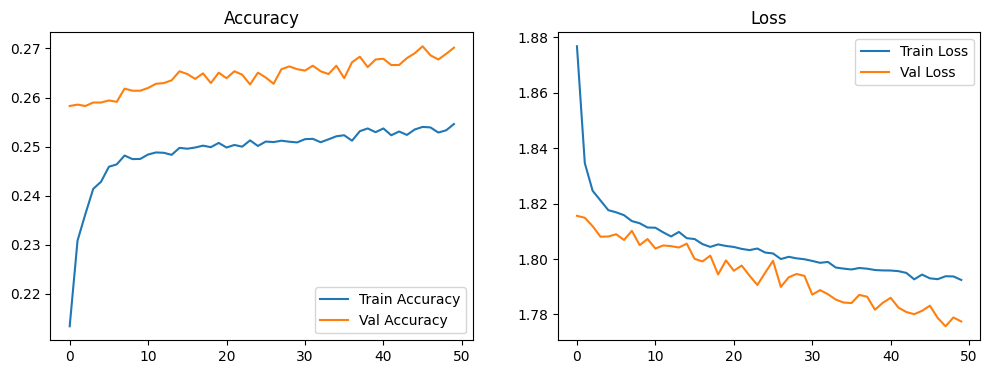

In [7]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label="Train Accuracy")
plt.plot(history.history['val_accuracy'], label="Val Accuracy")
plt.legend()
plt.title("Accuracy")

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label="Train Loss")
plt.plot(history.history['val_loss'], label="Val Loss")
plt.legend()
plt.title("Loss")

plt.show()